## Analyze CSV file

In [1]:
import os

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages "
    "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.6,"
    "org.apache.spark:spark-streaming-kafka-0-10_2.12:3.5.6 "
    "pyspark-shell"
)

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("read_test_stream") \
        .getOrCreate()

final_df = spark.read.csv("/home/guest/notebooks/data/output/date=*/hour=*", header=True, inferSchema=True)
final_df.take(5)

from pyspark.sql.functions import col

final_df.orderBy(col("window_start").asc()).coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("/home/guest/notebooks/final_output/")

:: loading settings :: url = jar:file:/home/guest/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/guest/.ivy2/cache
The jars for the packages stored in: /home/guest/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a3dc5a30-a5e8-4d29-88f8-f8065b51f4c0;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.6 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.6 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in c

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [3]:
# Using '*' pattern 
print('\nFile name:\n')
for name in glob.glob('/home/guest/notebooks/final_output/*.csv'):
    print(name)


File name:

/home/guest/notebooks/final_output/part-00000-98d68680-3df8-475d-8742-75b8a6b2c538-c000.csv


In [4]:
pandas_df = pd.read_csv(f"{name}")
pandas_df.tail()

,sensor,count,avg,std,max,min,range,count_miss,max_delay,out_of_control,window_start,window_end
145,sensor-2,4,2.205,1.794,4.212,-0.080,4.293,1,117.0,False,2025-07-01T12:47:00.000Z,2025-07-01T12:48:00.000Z
146,sensor-1,7,1.680,1.900,4.916,-1.174,6.090,0,119.0,False,2025-07-01T12:47:00.000Z,2025-07-01T12:48:00.000Z
147,sensor-2,19,3.532,3.193,9.273,-0.055,9.327,0,114.0,False,2025-07-01T12:48:00.000Z,2025-07-01T12:49:00.000Z
148,sensor-1,16,21.137,9.545,3.581,0.101,3.480,0,116.0,True,2025-07-01T12:48:00.000Z,2025-07-01T12:49:00.000Z
149,sensor-3,5,2.190,1.623,4.125,0.065,4.060,0,10.0,False,2025-07-01T12:48:00.000Z,2025-07-01T12:49:00.000Z


In [5]:
pandas_df["datetime"] = pd.to_datetime(pandas_df["window_end"])

In [6]:
sorted_df = pandas_df.sort_values(by='datetime').set_index("datetime")

In [7]:
sorted_df['range_max_min'] = sorted_df['max'] - sorted_df['min']

In [8]:
sorted_df.groupby("sensor").count()

,count,avg,std,max,min,range,count_miss,max_delay,out_of_control,window_start,window_end,range_max_min
sensor,,,,,,,,,,,,
sensor-1,51,51,50,51,51,51,51,51,51,51,51,51
sensor-2,51,51,49,51,51,51,51,51,51,51,51,51
sensor-3,48,48,48,48,48,48,48,48,48,48,48,48


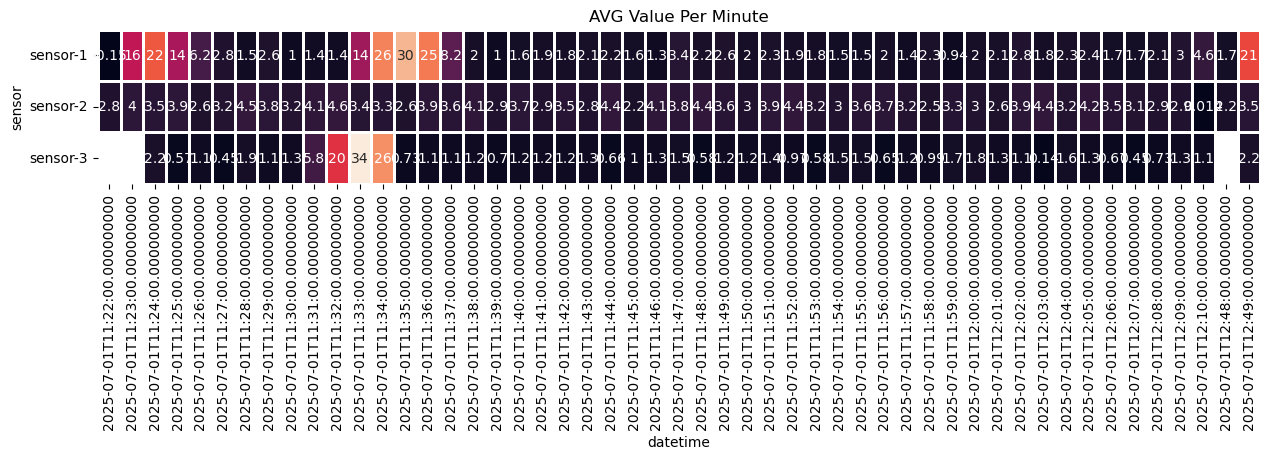

In [9]:
df_avg = sorted_df[["sensor", "avg"]].pivot(columns='sensor', values='avg')

#sorted_df.groupby("sensor").avg_obs.plot(figsize=(15,5))
#plt.legend()
#plt.plot()

plt.figure(figsize=(15, 2))
sns.heatmap(df_avg.T, 
            annot=True, 
            cbar=False, 
            linewidths=1, 
            linecolor='white', )
plt.title("AVG Value Per Minute")
plt.show()

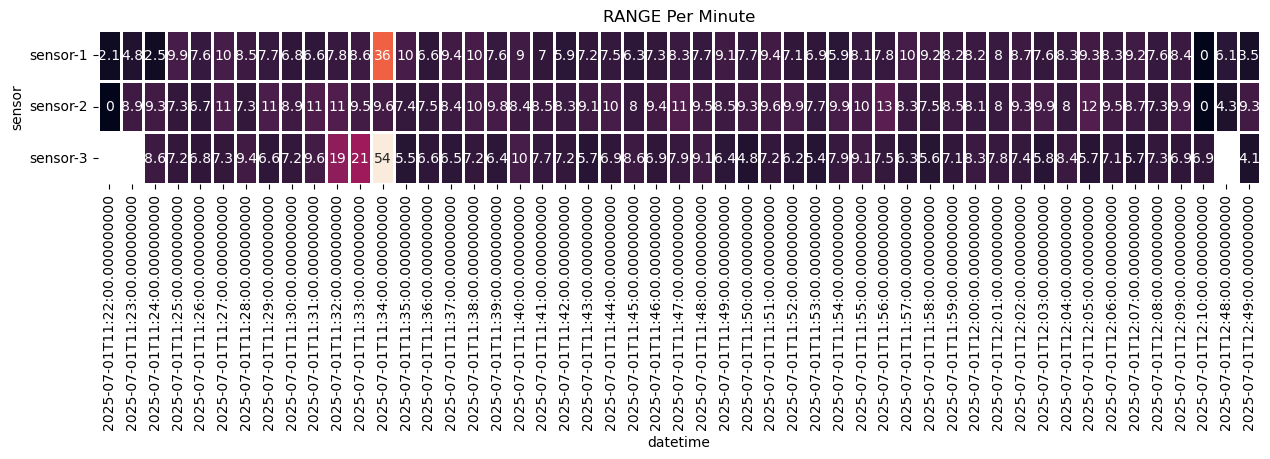

In [10]:
df_range = sorted_df[["sensor", "range_max_min"]].pivot(columns='sensor', values='range_max_min')

#sorted_df.groupby("sensor").range_max_min.plot(figsize=(15,5))
#plt.legend()
#plt.plot()

plt.figure(figsize=(15, 2))
sns.heatmap(df_range.T, 
            annot=True, 
            cbar=False, 
            linewidths=1, 
            linecolor='white')
plt.title("RANGE Per Minute")
plt.show()

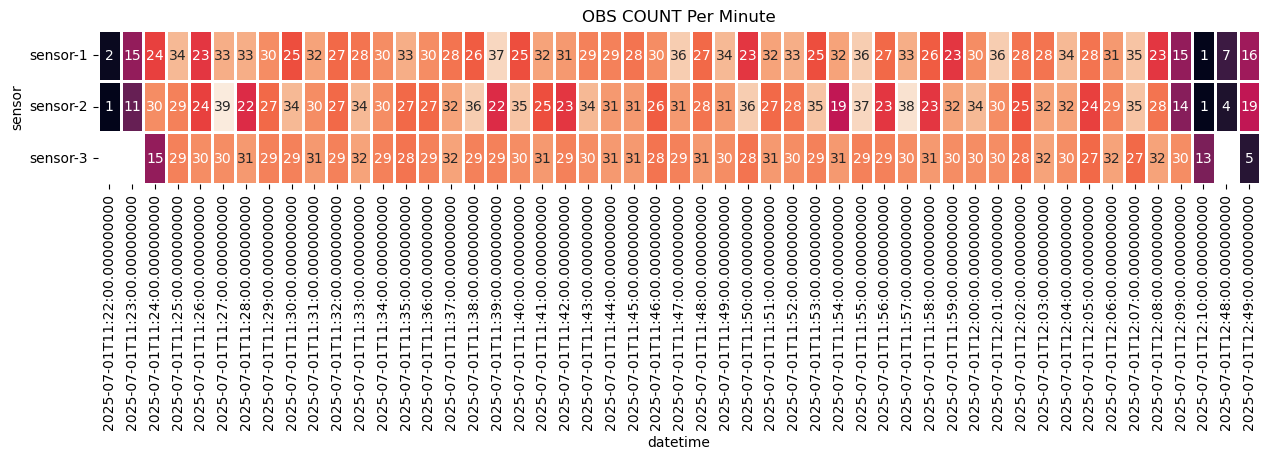

In [11]:
df_counts = sorted_df[["sensor", "count"]].pivot(columns='sensor', values='count')

plt.figure(figsize=(15, 2))
sns.heatmap(df_counts.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.title("OBS COUNT Per Minute")
plt.show()

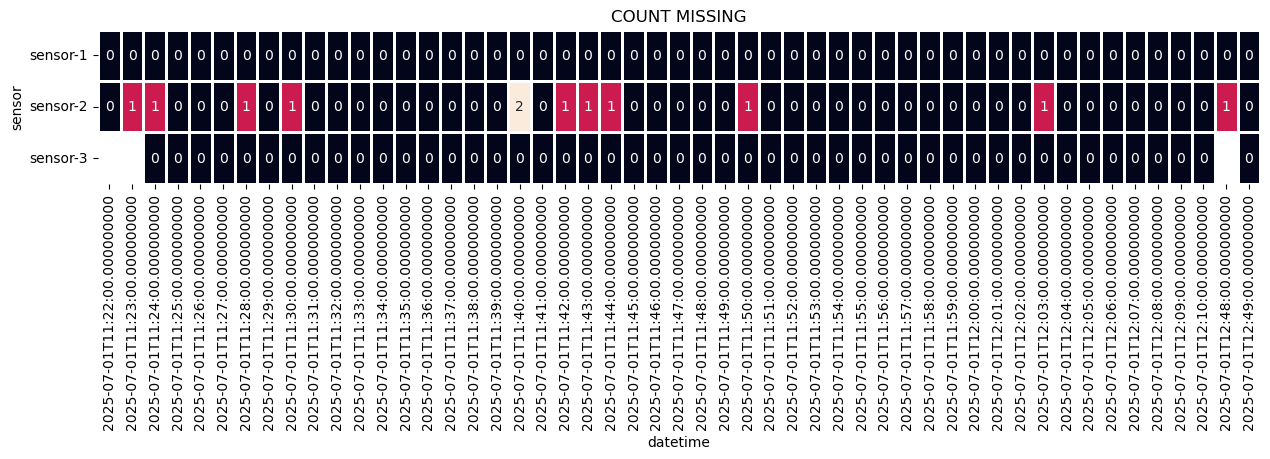

In [12]:
df_misses = sorted_df[["sensor", "count_miss"]].pivot(columns='sensor', values='count_miss')

plt.figure(figsize=(15, 2))
sns.heatmap(df_misses.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.title("COUNT MISSING")
plt.show()


/tmp/ipykernel_39394/3952426946.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out_of_control = sorted_df[["sensor", "out_of_control"]].pivot(columns='sensor', values='out_of_control').fillna(0).astype(int)


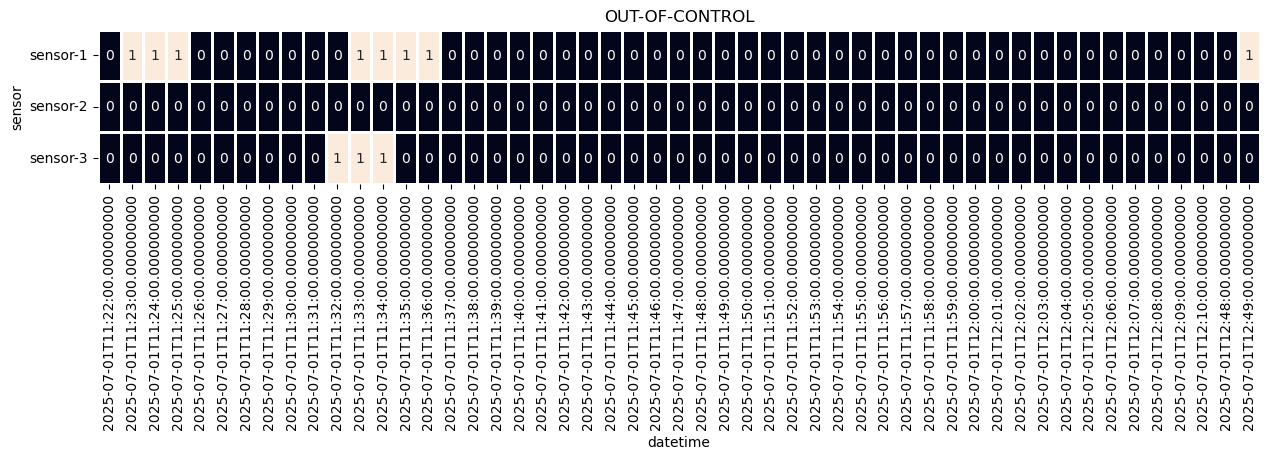

In [22]:
df_out_of_control = sorted_df[["sensor", "out_of_control"]].pivot(columns='sensor', values='out_of_control').fillna(0).astype(int)

plt.figure(figsize=(15, 2))
sns.heatmap(df_out_of_control.T, annot=True, cbar=False, 
                    linewidths=1, 
                    linecolor='white', )
plt.title("OUT-OF-CONTROL")
plt.show()

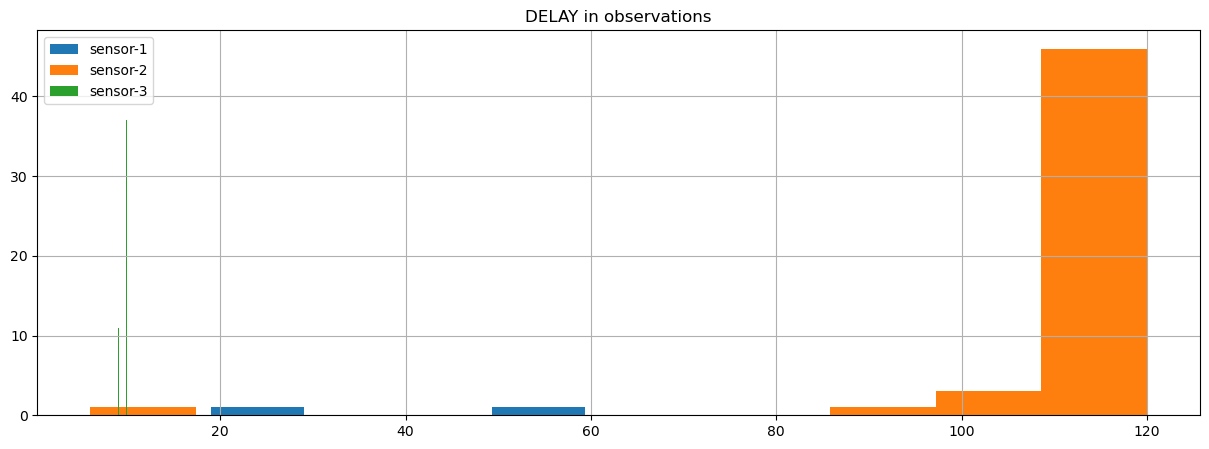

In [13]:
plt.figure(figsize=(15, 5))
sorted_df.groupby("sensor").max_delay.hist(legend=True)
plt.title("DELAY in observations")
plt.show()